In [2]:
import scanpy as sc
import anndata2ri
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging

# Import rpy2 modules for R interoperability
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri

In [3]:
# Activate automatic conversion between AnnData and R objects
anndata2ri.activate()
numpy2ri.activate()

# Suppress rpy2 logging messages for clarity
logging.getLogger("rpy2").setLevel(logging.ERROR)

# ------------------------------------------------
# 1. Load the Normalized Dataset
# ------------------------------------------------
adata = sc.read("/Volumes/Jagannath/Projects/Single_Cell_Upstream/single_cell/s4d8_shifted_log_normalization.h5ad")
print("Loaded normalized AnnData object with shape:", adata.shape)


Loaded normalized AnnData object with shape: (4053, 36601)


/var/folders/pv/2m5s9svn5tzdnmz917lwq0480000gn/T/ipykernel_16776/636165830.py:2: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
# ------------------------------------------------
# 2. Set Up the R Environment and Load scry
# ------------------------------------------------
ro.r('''
if (!requireNamespace("scry", quietly = TRUE)) {
    if (!requireNamespace("BiocManager", quietly = TRUE))
        install.packages("BiocManager")
    BiocManager::install("scry")
}
library(scry)
''')



The downloaded binary packages are in
	/var/folders/pv/2m5s9svn5tzdnmz917lwq0480000gn/T//Rtmp0dRR98/downloaded_packages
Update all/some/none? [a/s/n]: 
The downloaded binary packages are in
	/var/folders/pv/2m5s9svn5tzdnmz917lwq0480000gn/T//Rtmp0dRR98/downloaded_packages


In [5]:
# ------------------------------------------------
# 3. Push the AnnData Object to R
# ------------------------------------------------
# This makes the AnnData object available in R as "adata"
ro.globalenv["adata"] = adata

# ------------------------------------------------
# 4. Compute Deviance Using scry in R
# ------------------------------------------------
# Call devianceFeatureSelection on the raw counts (adata.X)
ro.r('sce <- devianceFeatureSelection(adata, assay = "X")')
# Extract the binomial deviance values from the rowData of the SingleCellExperiment object
ro.r('binomial_deviance <- t(rowData(sce)$binomial_deviance)')

# Retrieve the 'binomial_deviance' variable from R into Python and convert it to a NumPy array.
binomial_deviance = np.array(ro.globalenv["binomial_deviance"]).flatten()
print("Computed binomial deviance vector shape:", binomial_deviance.shape)


Computed binomial deviance vector shape: (36601,)


In [7]:
# ------------------------------------------------
# 5. Select Top 4,000 Highly Deviant Genes
# ------------------------------------------------
# Sort the deviance values and obtain indices of the top 4,000 genes.
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

# Save the Boolean mask and the deviance values in adata.var
adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance
print("Number of highly deviant genes selected:", mask.sum())


Number of highly deviant genes selected: 4000


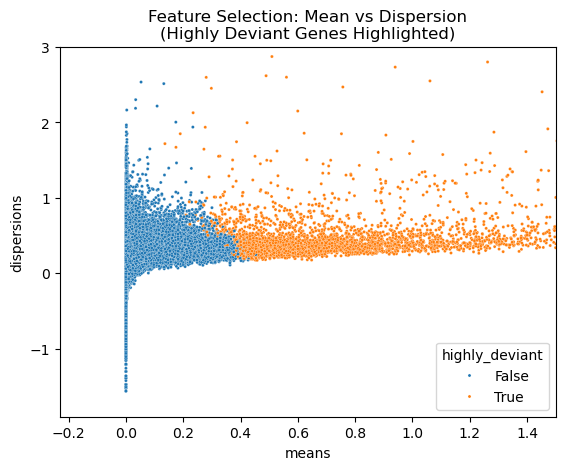

Feature selection complete. Updated AnnData object saved as 's4d8_feature_selection.h5ad'.


In [9]:
# ------------------------------------------------
# 6. Visualize Feature Selection Results
# ------------------------------------------------
# Compute gene-level means and dispersions using one of the normalized layers.
# (Here we use the "scran_normalization" layer; adjust if needed.)
# Instead of using the 'scran_normalization' layer, use 'log1p_norm' if available:
sc.pp.highly_variable_genes(adata, layer="log1p_norm")

# Create a scatter plot of gene means vs. dispersions, highlighting highly deviant genes.
ax = sns.scatterplot(data=adata.var, x="means", y="dispersions", hue="highly_deviant", s=5)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.title("Feature Selection: Mean vs Dispersion\n(Highly Deviant Genes Highlighted)")
plt.show()

# ------------------------------------------------
# 7. Save the Updated AnnData Object
# ------------------------------------------------
adata.write("s4d8_feature_selection.h5ad")
print("Feature selection complete. Updated AnnData object saved as 's4d8_feature_selection.h5ad'.")